## About the Task:

Guest Journey Patterns:
1. Use process mining or sequence analysis to identify common guest journey paths.
2. Compare these patterns across segments to uncover opportunities for personalization and operational improvements.


## About the Dataset

**Theme Park Attraction Visits Dataset**

Dataset Information:

This dataset comprises a set of users and their visits to various attractions in five theme parks (Disneyland, Epcot, California Adventure, Disney Hollywood and Magic Kindgom). The user-attraction visits are determined based on geo-tagged Flickr photos that are: (i) posted from Aug 2007 to Aug 2017 and retrieved using the Flickr API; (ii) then mapped to specific attraction location and attraction categories; and (iii) then grouped into individual travel sequences (consecutive user-attraction visits that differ by <8hrs). Other associated datasets are the "List of Attractions/POIs" dataset ("POI-{themeParkName}.csv" files from "poiList-sigir17.zip") and "Attraction/POI Cost-Profit Table" dataset ("costProfCat-{themeParkName}POI-all.csv" files from "costProf-sigir17.zip").

All user-attraction visits in each themepark are stored in a single csv file that contains the following columns/fields:

- id (photoID): identifier of the photo based on Flickr.

- nsid (userID): identifier of the user based on Flickr.

- dateTaken: the date/time that the photo was taken (unix timestamp format).

- poiID: identifier of the attraction (Flickr photos are mapped to attraction based on their lat/long).

- poiTheme: category of the attraction (e.g., Roller Coaster, Family, Water, etc).

- poiFreq: number of times this attraction has been visited.

- rideDuration: the normal ride duration of this attraction.

- seqID: travel sequence no. (consecutive attraction visits by the same user that differ by <8hrs are grouped as one travel sequence).

Places of Interest (POI) for Disney HollyWood

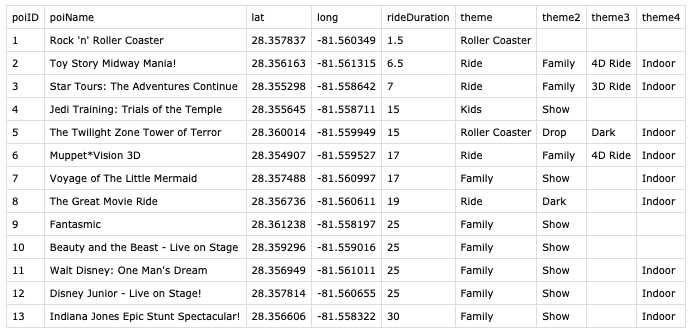

In [14]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import os

# List files in your Google Drive
drive_path = "/content/drive/My Drive/Guest Journey Analysis/data"
os.listdir(drive_path)

['userVisits-disHolly-allPOI.csv', 'data-sigir17.zip']

In [22]:
# Load the dataset
file_path = "/content/drive/My Drive/Guest Journey Analysis/data/userVisits-disHolly-allPOI.csv"
df = pd.read_csv(file_path, delimiter=";")

# Check the first few rows
df.head()

,id,nsid,takenUnix,poiID,poiTheme,poiFreq,rideDuration,seqID
0,4617275371,10005149@N03,1274095158,5,Roller Coaster,2616,900,1
1,8235744245,10008488@N07,1354345925,6,Ride,5969,1020,2
2,8236810104,10008488@N07,1354346676,6,Ride,5969,1020,2
3,9513896740,100320969@N08,1375140897,2,Ride,2936,390,3
4,9511104781,100320969@N08,1375140906,2,Ride,2936,390,3


We have 1972 distinct users for this dataset.

In [37]:
df["nsid"].nunique()

1972

In [38]:
df["id"].nunique()

41983

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41983 entries, 0 to 41982
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            41983 non-null  int64 
 1   nsid          41983 non-null  object
 2   takenUnix     41983 non-null  int64 
 3   poiID         41983 non-null  int64 
 4   poiTheme      41983 non-null  object
 5   poiFreq       41983 non-null  int64 
 6   rideDuration  41983 non-null  int64 
 7   seqID         41983 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 2.6+ MB


## Data Preprocessing

In [23]:
# Convert UNIX timestamp to datetime
df["takenUnix"] = pd.to_datetime(df["takenUnix"], unit="s")

# Rename column for clarity
df.rename(columns={"takenUnix": "dateTaken"}, inplace=True)

# Sort the data
df = df.sort_values(by=["id", "dateTaken"])

# Display first few rows
df.head()

,id,nsid,dateTaken,poiID,poiTheme,poiFreq,rideDuration,seqID
2002,1227085805,11632646@N02,2007-08-24 09:51:04,6,Ride,5969,1020,195
940,1323713653,10905622@N03,2007-09-04 04:53:54,1,Roller Coaster,5825,90,106
1637,1343441367,11438118@N00,2007-09-06 02:39:34,5,Roller Coaster,2616,900,170
1638,1343446737,11438118@N00,2007-09-06 02:43:11,5,Roller Coaster,2616,900,170
1639,1343664239,11438118@N00,2007-09-06 03:38:55,1,Roller Coaster,5825,90,170


In [24]:
# Drop any missing values
df = df.dropna()

# Check if there are duplicate entries
df.duplicated().sum()

np.int64(0)

## Identify Guest Journey Sequences

In [49]:
#! pip install pm4py
import pm4py
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
import networkx as nx

In [50]:
# Ensure proper data types
df['dateTaken'] = pd.to_datetime(df['dateTaken'])  # Convert to datetime
df['poiID'] = df['poiID'].astype(str)  # Convert IDs to strings to avoid comparison issues

# Convert the dataframe to an event log format for process mining
event_log = df.copy()

# Sort the data by user and timestamp
event_log = event_log.sort_values(['nsid', 'dateTaken'])

# Create the required columns with proper formats
event_log_pm4py = pd.DataFrame({
    'case:concept:name': event_log['nsid'].astype(str),
    'concept:name': event_log['poiID'].astype(str),
    'time:timestamp': event_log['dateTaken']
})

# Convert to PM4Py event log format
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

event_log_pm4py = dataframe_utils.convert_timestamp_columns_in_df(event_log_pm4py)
log = log_converter.apply(event_log_pm4py)


## Visualising Guest Journey Patterns

### Petri net

A process model with the numbers representing attraction IDs (poiID)
- black circle is the source node (starting point)
- black square is the sink node (ending point)
- the numbered rectangles represent different POIs that guests visit
- all attractions cna be reached directly from the source node, and all lead directly to the sink node, suggesting a non-sequential patern of attraction visits

Insights
- Flexible pathways: guests don't follow a single linear path through attractions.
- Lack of direct connections: guests often don't folow a predictable sequence.
- Source and sink nodes likely represent park entrance and exit
-

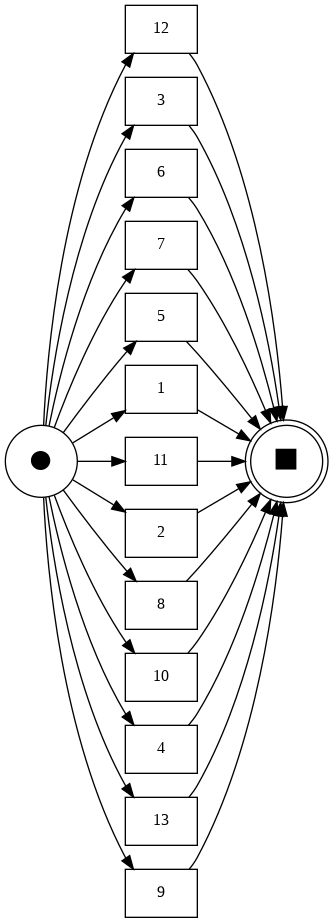

In [46]:
# Visualize the Petri net
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

### Direct Follows Graph
This shows the flow of guests between attractions, with edge thickness representing frequency of transitions

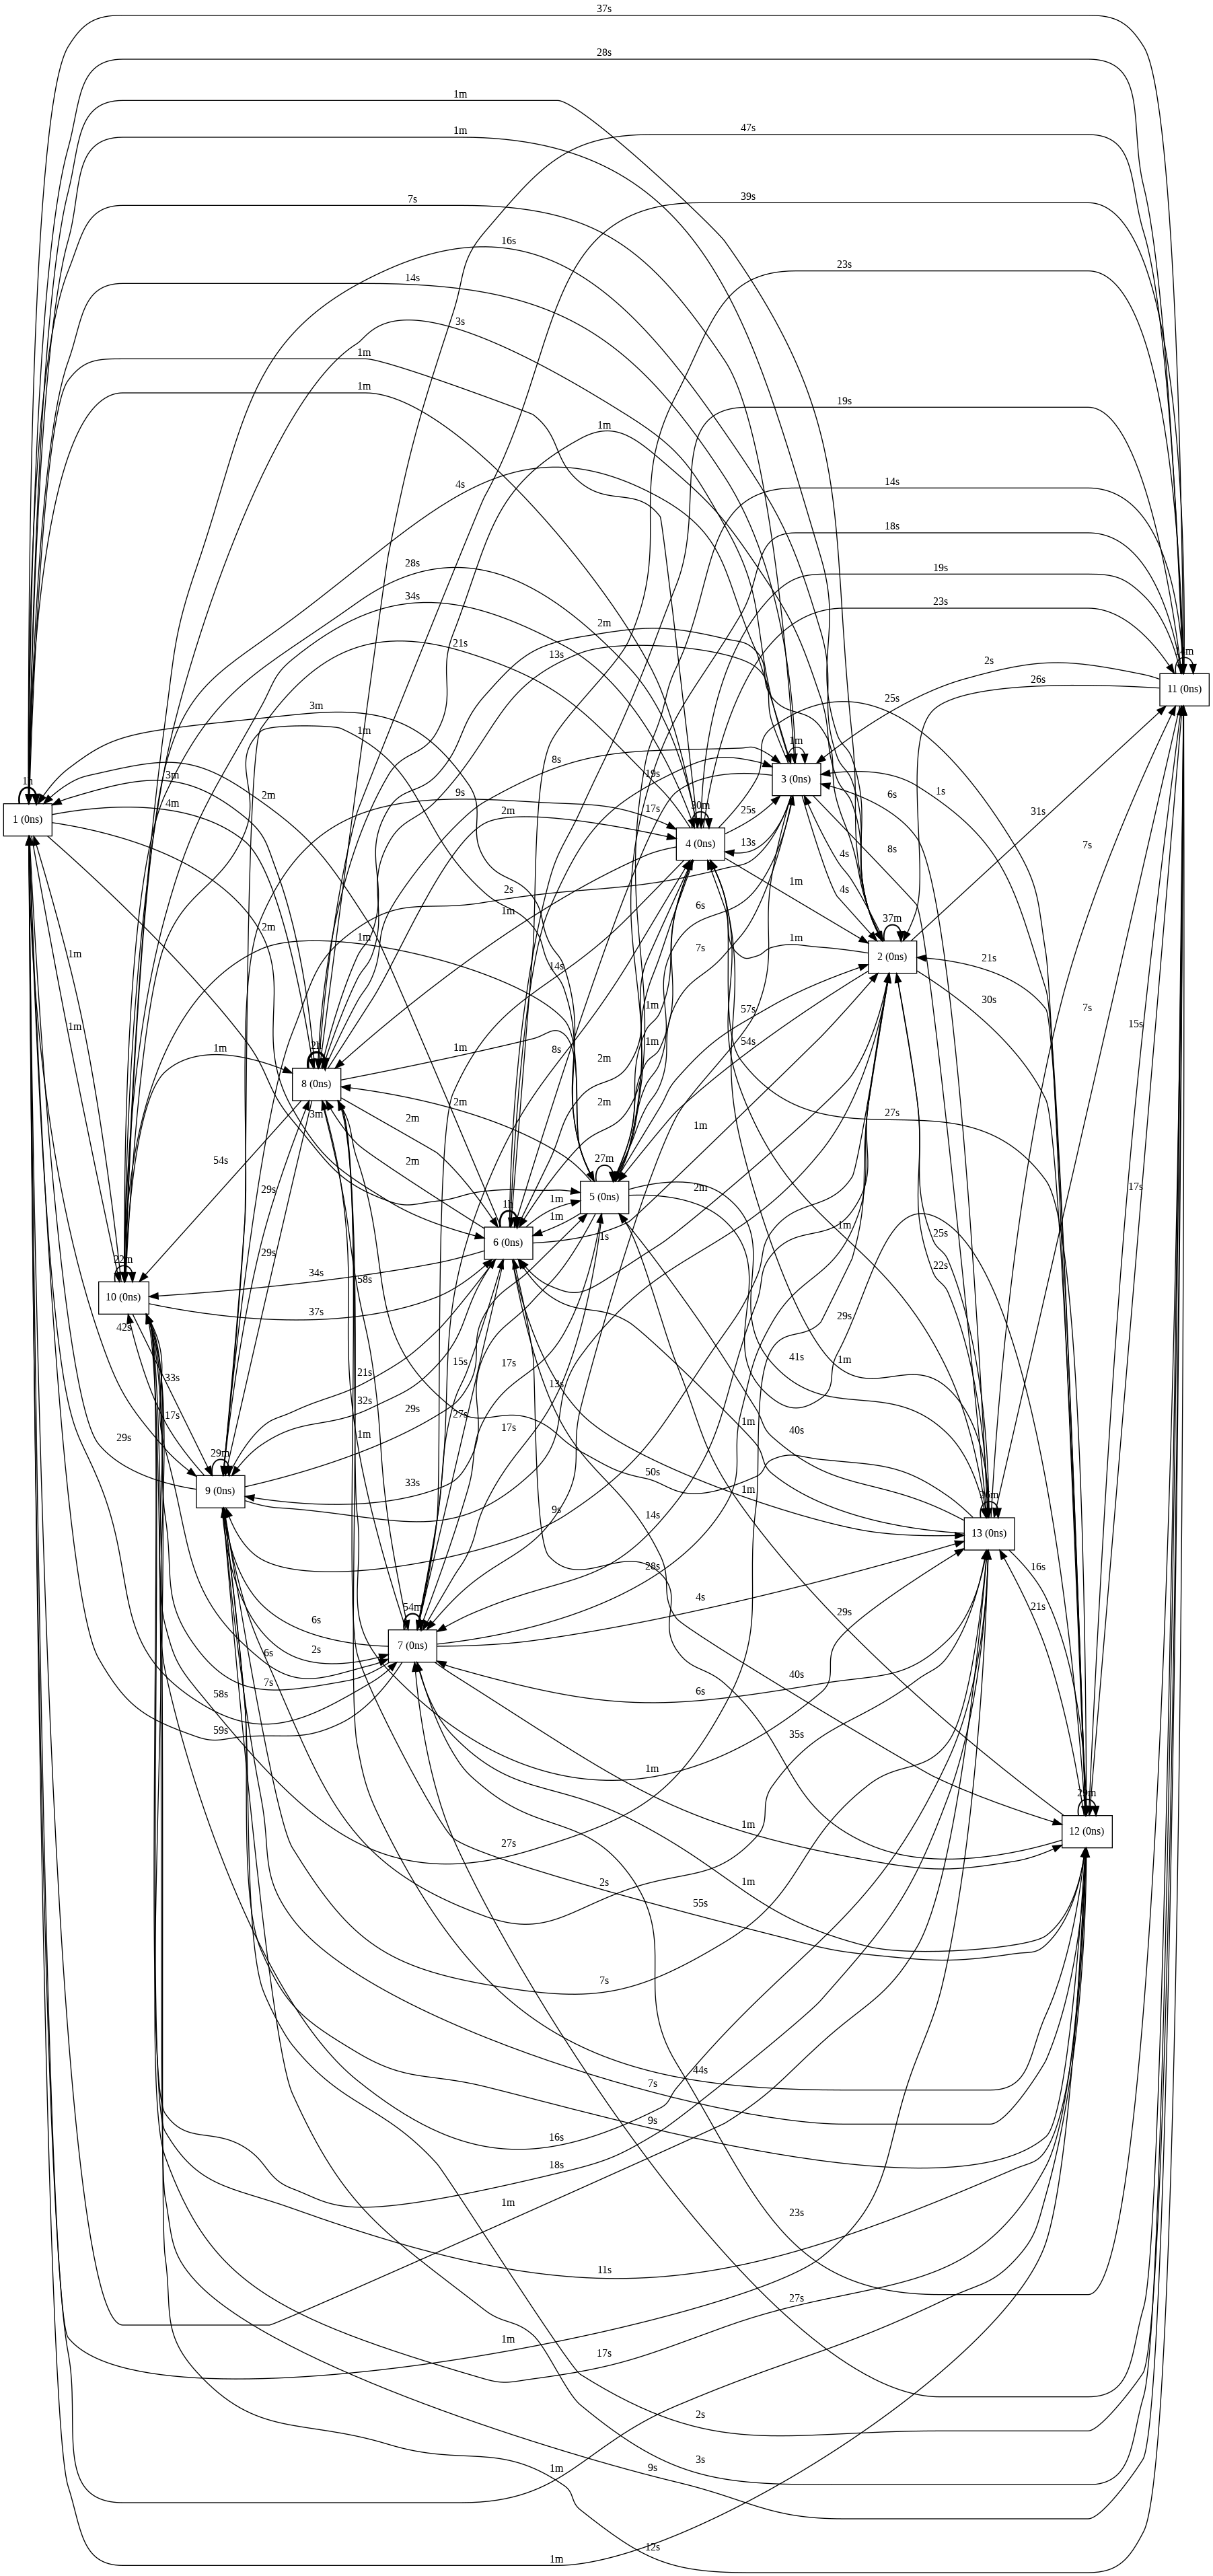

In [51]:
# Generate and visualize a directly-follows graph
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization

dfg = dfg_discovery.apply(log)
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)


In [52]:
# Extract variant statistics correctly
from pm4py.statistics.variants.log import get as variants_module
variants = variants_module.get_variants(log)
print("Top 5 most common guest journey patterns:")
sorted_variants = sorted([(v, len(variants[v])) for v in variants], key=lambda x: x[1], reverse=True)
for i, (variant, count) in enumerate(sorted_variants[:5]):
    print(f"Pattern {i+1}: {variant} (frequency: {count})")

Top 5 most common guest journey patterns:
Pattern 1: ('5',) (frequency: 88)
Pattern 2: ('1',) (frequency: 78)
Pattern 3: ('4',) (frequency: 74)
Pattern 4: ('8',) (frequency: 73)
Pattern 5: ('6',) (frequency: 68)


### NetworkX



Most common journey patterns:
Frequency: 220, Pattern: 5
Frequency: 204, Pattern: 8
Frequency: 196, Pattern: 1
Frequency: 189, Pattern: 6
Frequency: 168, Pattern: 4


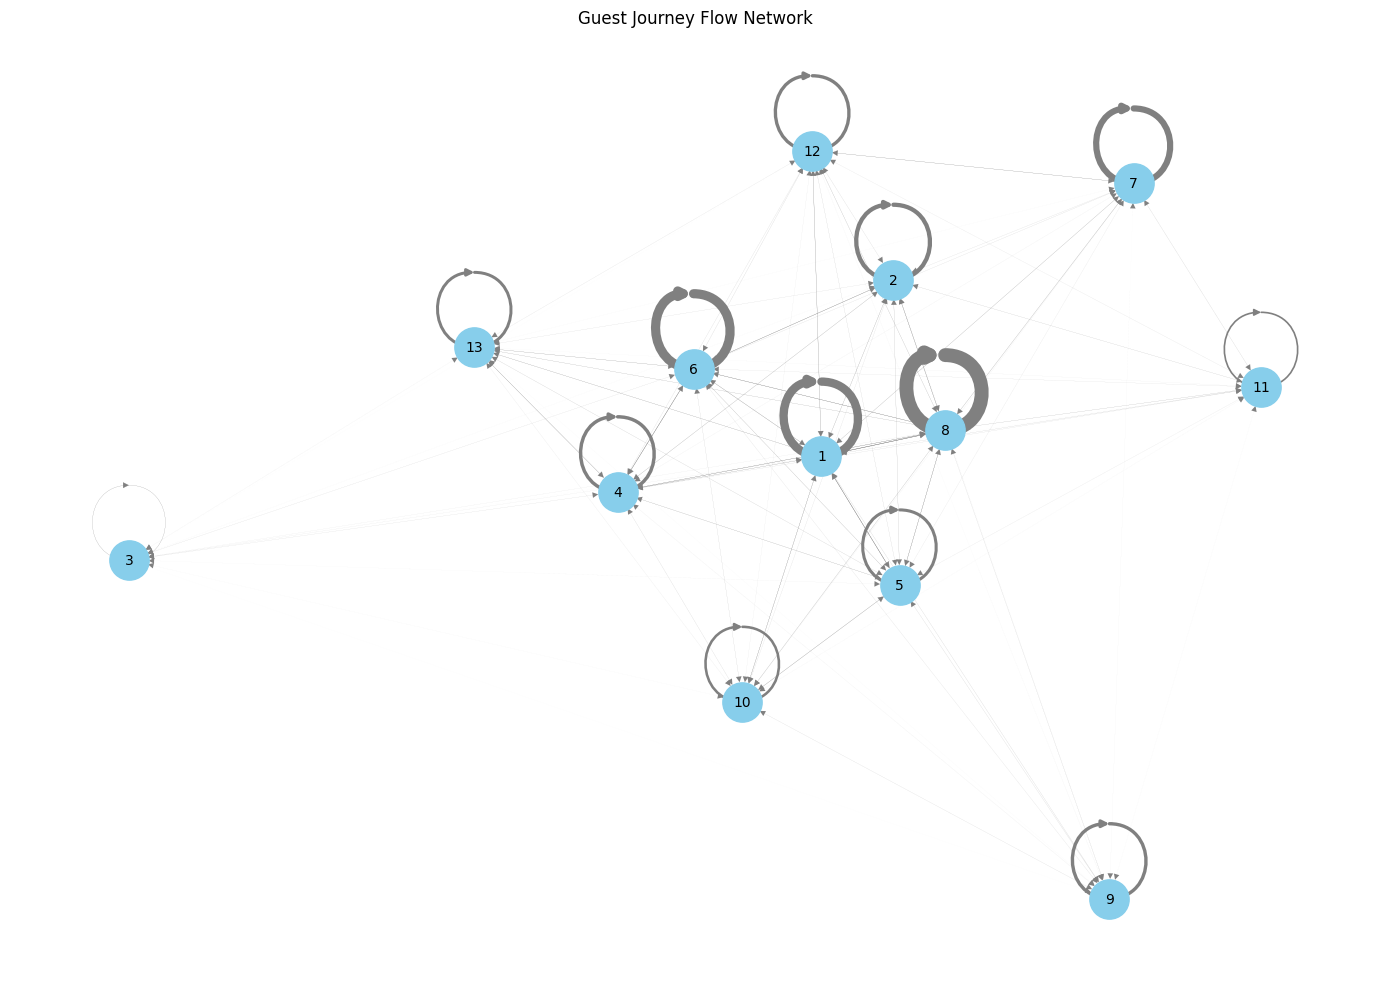


Top transitions for Ride:
  1. 8 → 8 (frequency: 7408)
  2. 6 → 6 (frequency: 4875)
  3. 2 → 2 (frequency: 2270)
  4. 8 → 6 (frequency: 197)
  5. 6 → 8 (frequency: 175)

Top transitions for Roller Coaster:
  1. 1 → 1 (frequency: 4631)
  2. 5 → 5 (frequency: 1671)
  3. 1 → 5 (frequency: 257)
  4. 5 → 1 (frequency: 246)

Top transitions for Family:
  1. 7 → 7 (frequency: 3257)
  2. 12 → 12 (frequency: 1791)
  3. 9 → 9 (frequency: 1769)
  4. 13 → 13 (frequency: 1603)
  5. 10 → 10 (frequency: 1398)

Top transitions for Kids:
  1. 4 → 4 (frequency: 1937)


In [53]:
# Alternative approach using NetworkX for journey analysis
# Group attractions by visitor (nsid) and visit sequence (seqID)
visitor_journeys = {}
for visitor, visitor_data in df.groupby('nsid'):
    # Sort by dateTaken to get chronological order
    visitor_data = visitor_data.sort_values('dateTaken')

    # Group by seqID to separate different park visits
    for seq_id, seq_data in visitor_data.groupby('seqID'):
        journey_key = f"{visitor}_{seq_id}"
        visitor_journeys[journey_key] = list(seq_data['poiID'].astype(str))

# Count journey patterns (attraction sequences)
journey_patterns = {}
for journey in visitor_journeys.values():
    journey_str = ' → '.join(journey)
    journey_patterns[journey_str] = journey_patterns.get(journey_str, 0) + 1

# Show most common journey patterns
print("\nMost common journey patterns:")
for pattern, count in sorted(journey_patterns.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"Frequency: {count}, Pattern: {pattern}")

# Create transition graph (showing how guests move between attractions)
transitions = {}
for journey in visitor_journeys.values():
    if len(journey) < 2:
        continue
    for i in range(len(journey) - 1):
        source = journey[i]
        target = journey[i+1]
        transition = (source, target)
        transitions[transition] = transitions.get(transition, 0) + 1

# Create directed graph of transitions
G = nx.DiGraph()
for (source, target), weight in transitions.items():
    G.add_edge(source, target, weight=weight)

# Visualize the graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42)  # Fixed seed for reproducibility
edge_weights = [G[u][v]['weight']/max(transitions.values())*10 for u, v in G.edges()]

nx.draw_networkx(G, pos,
                node_color='skyblue',
                node_size=800,
                font_size=10,
                width=edge_weights,
                edge_color='gray',
                with_labels=True,
                arrows=True)
plt.title('Guest Journey Flow Network')
plt.axis('off')
plt.tight_layout()
plt.show()

# Analyze journeys by theme
theme_transitions = {}
for theme in df['poiTheme'].unique():
    theme_df = df[df['poiTheme'] == theme]
    theme_transitions[theme] = {}

    # Group by visitor and sequence
    for visitor, visitor_data in theme_df.groupby('nsid'):
        visitor_data = visitor_data.sort_values('dateTaken')
        for seq_id, seq_data in visitor_data.groupby('seqID'):
            journey = list(seq_data['poiID'].astype(str))
            if len(journey) < 2:
                continue
            for i in range(len(journey) - 1):
                source = journey[i]
                target = journey[i+1]
                transition = (source, target)
                if transition not in theme_transitions[theme]:
                    theme_transitions[theme][transition] = 0
                theme_transitions[theme][transition] += 1

# Show top transitions for each theme
for theme, transitions in theme_transitions.items():
    if transitions:
        print(f"\nTop transitions for {theme}:")
        sorted_transitions = sorted(transitions.items(), key=lambda x: x[1], reverse=True)
        for i, ((source, target), count) in enumerate(sorted_transitions[:5]):
            print(f"  {i+1}. {source} → {target} (frequency: {count})")

Key Observations:

- Self-loops: Many attractions (nodes) have circular arrows pointing back to themselves, guests often visit the same attraction multiple times during their visit.
Centrality: Attractions 1, 6, and 8 appear to be more central in the network with thicker connection loops and more connections to other attractions. These are likely key attractions that serve as hubs within the park. (Rock 'n' Roller Coaster, Muppet Vision 3D, The Great Movie Ride)
- Isolated Attractions: Nodes 3, 9, and 11 appear relatively isolated with fewer connections, suggesting they might be standalone experiences or attractions that don't typically fit into the main guest flow.
- Clusters: There seem to be clusters of attractions that are more connected to each other, suggesting themed areas or natural groupings of attractions that guests tend to experience together.
- Connection Thickness: The thickness of connections (especially the self-loops) indicates frequency - thicker lines mean more guests follow that path.

Analytical Insights:

- Hub Attractions: Attractions 1, 6, and 8 function as hub attractions that guests visit either multiple times or use as connection points between other attractions.
- Common Pathways: The network shows several common pathways between attractions, particularly between 1-8, 1-5, and 5-10. These represent frequent guest movement patterns.
- Repeatable Experiences: The strong self-loops (especially on attractions 6, 8, and 1) suggest these are either highly repeatable experiences or attractions where guests spend significant time.
- Isolated Experiences: Attraction 3: 'Star Tours: The Adventure Continues" appears most isolated, suggesting it might be:
  - Located far from other attractions
  - Appealing to a specific subset of guest
  - A unique experience that doesn't naturally connect to others


Business Applications:

- Operational Planning: Focus staffing and resources on hub attractions (1, 6, 8) as they handle the highest guest traffic.
- Wayfinding Improvements: Strengthen pathways between commonly connected attractions to improve guest flow.
- Experience Design: Consider creating more connections to isolated attractions (3, 9, 11) to better integrate them into the overall guest experience.
- Crowd Management: Monitor the hub attractions for potential congestion and implement queue management strategies.
- Attraction Placement: For future development, consider placing new attractions along the most traveled paths to maximize visibility.

## Next Steps
- Add wait time analysis by calculating time deltas between attractions
- Identify "anchor attractions" that drive specific journey patterns
- Perform time-of-day analysis to see how patterns change throughout the day
- Create guest segments based on journey patterns rather than just attraction preferences